# <left>#4: Measuring Trees - interactive Python notebook

## Howdy! 

This ipynb is the fourth step towards automating the process of measuring trees.

This notebook assumes the ipynb resides directly in the “main directory” with a ‘_input’ folder housing the input files. We will create and use an ‘output’ folder for output files.

- This notebook will take the `TreeLS` output CSV as an input and join to existing inventory list to create one master inventory. 
- After joining, subsets will be created to run stats. 
- Outputs will be CSV and SHP of master inventory list along with scatterplots. 


***
### 1.0 - Setup Notebook

#### Import the necessary modules 

In [1]:
import os 
import math
import arcpy 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

#### Set workspace 
Creates an "output" folder and sets it as the current working directory so all outputs below don't need a folder specified. 
This also creates other folders such as "figures". 

In [2]:
output = './output/'
if not os.path.exists(output):
    os.makedirs(output)

path = os.getcwd() + '\\output'
os.chdir(path)

arcpy.env.workspace = path
arcpy.env.overwriteOutput = True

figpath = '../figures/'
if not os.path.exists(figpath):
    os.makedirs(figpath)

output_dir = os.getcwd()
print(output_dir)

main_dir = os.path.dirname(output_dir)
print(main_dir)

c:\Temp\sample_code\04_TreeLS_inv\output
c:\Temp\sample_code\04_TreeLS_inv


### 2.0 - Load Data

If using the "_input" folder for model inputs, this cell lists the files and specific extentions in the folder. 

In [3]:
in_dir = '../_input/'

ext = '.shp'
for file in os.listdir(in_dir):
    if file.endswith(ext):
        print(ext + ' files in "_input" folder: ' + file)

ext = '.csv'
for file in os.listdir(in_dir):
    if file.endswith(ext):
        print(ext + ' files in "_input" folder: ' + file)

.shp files in "_input" folder: crowns1.shp
.csv files in "_input" folder: field_tt_cw_out.csv
.csv files in "_input" folder: xyh_dbh.csv


Specifies the inputs from "_input" folder or from absolute path. 

In [4]:
in_crowns = in_dir + 'crowns1.shp'
# code tree crown areas

in_inv1 = in_dir + 'field_tt_cw_out.csv' 
# shp combo + tt + ca

in_inv2 = in_dir + 'xyh_dbh.csv' 
# code dbh, h 

Review the shp table. 

In [5]:
arcpy.conversion.ExportTable(in_crowns, 'out_in_crowns.csv')
crowns_df1 = pd.read_csv('out_in_crowns.csv')
crowns_df1.head()

,treeID,Z,npoints,cnvhll_
0,1.0,6.938,91,21.250
1,2.0,11.497,403,108.250
2,3.0,7.333,41,8.000
3,4.0,12.867,672,174.375
4,5.0,11.791,376,106.000


Check the inv tables. 

In [6]:
inv1_df1 = pd.read_csv(in_inv1)
inv1_df1.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,MBG_Width,MBG_Length,treeID,cw_avg,cw_pi,icw
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262,8.9890,8.830964,8.909982
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270,7.7930,7.420755,7.606878
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276,8.7350,8.611980,8.673490
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289,9.0225,8.731278,8.876889
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296,10.2105,10.155413,10.182956


In [7]:
inv2_df1 = pd.read_csv(in_inv2)
inv2_df1.head()

,Unnamed: 0,X,Y,H,DBH
0,1,753858.194836,3.388216e+06,9.206188,0.265165
1,2,753841.604340,3.388219e+06,5.051006,0.423896
2,3,753839.180690,3.388177e+06,3.099653,0.197642
3,4,753835.917843,3.388188e+06,9.223414,0.250000
4,5,753833.189031,3.388196e+06,7.956330,0.433013


Convert CSV to SHP. 

In [8]:
sr = arcpy.SpatialReference(32614)
    # 32614: WGS 1984 UTM Zone 14N
    # 5703: NAVD88 height (m)

inv1_shp = arcpy.management.XYTableToPoint(main_dir + r'/_input/field_tt_cw_out.csv', 
                                           'inv1_shp', 'X', 'Y', coordinate_system=sr)

In [9]:
sr = arcpy.SpatialReference(32614)
    # 32614: WGS 1984 UTM Zone 14N
    # 5703: NAVD88 height (m)

inv2_shp = arcpy.management.XYTableToPoint(main_dir + r'/_input/xyh_dbh.csv', 
                                           'inv2_shp', 'X', 'Y', coordinate_system=sr)

### 3.0 - Analysis

We want to correlate field measurements to algorithm measurements, so we need to clean them up and tie them together. <br>
First, we'll remove inv2 (dbh) points that do not intersect crown areas. 

In [10]:
dbh_sel = arcpy.management.SelectLayerByLocation(inv2_shp, select_features=in_crowns)
dbh_ca = arcpy.management.CopyFeatures(dbh_sel, 'dbh_ca.shp')

Next, we will add a spatial join, based on inv1 (tt_cw), within a search distance of 5m to dbh_ca. <br>
Export the new SHP. 

In [11]:
inv12join = arcpy.management.AddSpatialJoin(inv1_shp, inv2_shp, 
                                            match_option = 'CLOSEST', search_radius = 5)
inv_all = arcpy.conversion.ExportFeatures(inv12join, 'inv_all.shp')

In [12]:
arcpy.conversion.ExportTable('inv_all.shp', 'inv_all.csv')
inv_all_df1 = pd.read_csv('inv_all.csv')
inv_all_df1

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,MBG_Width,...,cw_pi,icw,OBJECTID,Join_Count,TARGET_FID,Field1,X_1,Y_1,H,DBH
0,754251.089289,3.389062e+06,0.325000,7.70,0.424,6.98,9.0,7.522,61.250,8.321,...,8.830964,8.909982,1,0,0,0,0.000000,0.000000e+00,0.000000,0.000000
1,754219.000144,3.389035e+06,0.274000,5.70,0.360,5.41,8.1,5.528,43.250,7.071,...,7.420755,7.606878,2,0,1,0,0.000000,0.000000e+00,0.000000,0.000000
2,754182.715187,3.389006e+06,0.315000,6.20,0.350,6.19,9.6,6.588,58.250,7.647,...,8.611980,8.673490,3,0,2,0,0.000000,0.000000e+00,0.000000,0.000000
3,754136.122764,3.388967e+06,0.307000,7.30,0.300,7.22,8.8,7.626,59.875,8.222,...,8.731278,8.876889,4,0,3,0,0.000000,0.000000e+00,0.000000,0.000000
4,754077.939157,3.388919e+06,0.310000,8.20,0.360,7.40,11.2,7.747,81.000,9.241,...,10.155413,10.182956,5,1,4,28,754077.505763,3.388918e+06,7.027784,0.364434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,754864.635162,3.390234e+06,0.533616,12.70,0.000,0.00,0.0,11.470,316.750,17.425,...,20.082296,21.897398,118,1,117,208,754864.421286,3.390235e+06,9.643123,0.559017
118,754875.293096,3.390251e+06,0.591828,11.60,0.000,0.00,0.0,10.949,280.375,18.000,...,18.894034,19.251767,119,0,118,0,0.000000,0.000000e+00,0.000000,0.000000
119,754862.508462,3.390263e+06,0.460850,9.00,0.000,0.00,0.0,10.008,138.125,12.298,...,13.261456,13.582228,120,0,119,0,0.000000,0.000000e+00,0.000000,0.000000
120,754889.910964,3.390275e+06,0.533616,10.50,0.000,0.00,0.0,11.791,106.000,10.910,...,11.617375,11.795687,121,0,120,0,0.000000,0.000000e+00,0.000000,0.000000


List all columns. 

In [13]:
for col in inv_all_df1: 
    print(col)

X
Y
dbh_m_f
h_m_f
dbh_m_mls
h_m_mls
cw_m_mls
h_m_tt
ca_m2
MBG_Width
MBG_Length
treeID
cw_avg
cw_pi
icw
OBJECTID
Join_Count
TARGET_FID
Field1
X_1
Y_1
H
DBH


Subset, rearrange, and rename the columns. 

In [14]:
inv_full = inv_all_df1[['X', 'Y',  'treeID',  'dbh_m_f', 'h_m_f', 'dbh_m_mls', 
                        'h_m_mls', 'cw_m_mls', 'h_m_tt', 'ca_m2', 'cw_avg', 
                        'cw_pi', 'icw', 'H', 'DBH']]
inv_full = inv_full.rename(columns={'cw_avg': 'cw_avg_m', 'cw_pi': 'cw_pi_m', 
                                    'icw': 'icw_m', 'H': 'h_m_tls', 'DBH': 'dbh_m_tls'}) 
inv_full.head()

,X,Y,treeID,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,cw_avg_m,cw_pi_m,icw_m,h_m_tls,dbh_m_tls
0,754251.089289,3.389062e+06,250,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.9890,8.830964,8.909982,0.000000,0.000000
1,754219.000144,3.389035e+06,258,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.7930,7.420755,7.606878,0.000000,0.000000
2,754182.715187,3.389006e+06,264,0.315,6.2,0.350,6.19,9.6,6.588,58.250,8.7350,8.611980,8.673490,0.000000,0.000000
3,754136.122764,3.388967e+06,277,0.307,7.3,0.300,7.22,8.8,7.626,59.875,9.0225,8.731278,8.876889,0.000000,0.000000
4,754077.939157,3.388919e+06,284,0.310,8.2,0.360,7.40,11.2,7.747,81.000,10.2105,10.155413,10.182956,7.027784,0.364434


Convert DBH m to cm and rearrange. 

In [15]:
inv_full['dbh_cm_f'] = inv_full['dbh_m_f'] * 100
inv_full['dbh_cm_mls'] = inv_full['dbh_m_mls'] * 100
inv_full['dbh_cm_tls'] = inv_full['dbh_m_tls'] * 100

inv_full = inv_full[['X', 'Y',  'treeID', 'dbh_cm_f', 'h_m_f', 'dbh_cm_mls', 'h_m_mls', 
                     'cw_m_mls', 'h_m_tt', 'ca_m2', 'cw_avg_m', 'cw_pi_m', 'icw_m', 
                     'h_m_tls', 'dbh_cm_tls']]
inv_full

,X,Y,treeID,dbh_cm_f,h_m_f,dbh_cm_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,cw_avg_m,cw_pi_m,icw_m,h_m_tls,dbh_cm_tls
0,754251.089289,3.389062e+06,250,32.500000,7.70,42.4,6.98,9.0,7.522,61.250,8.9890,8.830964,8.909982,0.000000,0.000000
1,754219.000144,3.389035e+06,258,27.400000,5.70,36.0,5.41,8.1,5.528,43.250,7.7930,7.420755,7.606878,0.000000,0.000000
2,754182.715187,3.389006e+06,264,31.500000,6.20,35.0,6.19,9.6,6.588,58.250,8.7350,8.611980,8.673490,0.000000,0.000000
3,754136.122764,3.388967e+06,277,30.700000,7.30,30.0,7.22,8.8,7.626,59.875,9.0225,8.731278,8.876889,0.000000,0.000000
4,754077.939157,3.388919e+06,284,31.000000,8.20,36.0,7.40,11.2,7.747,81.000,10.2105,10.155413,10.182956,7.027784,36.443449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,754864.635162,3.390234e+06,12,53.361601,12.70,0.0,0.00,0.0,11.470,316.750,23.7125,20.082296,21.897398,9.643123,55.901699
118,754875.293096,3.390251e+06,8,59.182799,11.60,0.0,0.00,0.0,10.949,280.375,19.6095,18.894034,19.251767,0.000000,0.000000
119,754862.508462,3.390263e+06,6,46.085000,9.00,0.0,0.00,0.0,10.008,138.125,13.9030,13.261456,13.582228,0.000000,0.000000
120,754889.910964,3.390275e+06,5,53.361601,10.50,0.0,0.00,0.0,11.791,106.000,11.9740,11.617375,11.795687,0.000000,0.000000


Copy for safety.

In [16]:
inv_full_copy = inv_full.copy()
inv_full_copy.head()

,X,Y,treeID,dbh_cm_f,h_m_f,dbh_cm_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,cw_avg_m,cw_pi_m,icw_m,h_m_tls,dbh_cm_tls
0,754251.089289,3.389062e+06,250,32.5,7.7,42.4,6.98,9.0,7.522,61.250,8.9890,8.830964,8.909982,0.000000,0.000000
1,754219.000144,3.389035e+06,258,27.4,5.7,36.0,5.41,8.1,5.528,43.250,7.7930,7.420755,7.606878,0.000000,0.000000
2,754182.715187,3.389006e+06,264,31.5,6.2,35.0,6.19,9.6,6.588,58.250,8.7350,8.611980,8.673490,0.000000,0.000000
3,754136.122764,3.388967e+06,277,30.7,7.3,30.0,7.22,8.8,7.626,59.875,9.0225,8.731278,8.876889,0.000000,0.000000
4,754077.939157,3.388919e+06,284,31.0,8.2,36.0,7.40,11.2,7.747,81.000,10.2105,10.155413,10.182956,7.027784,36.443449


NaN copy

In [17]:
inv_full_copy.replace(0, np.nan, inplace=True)
inv_full_nan = inv_full_copy
inv_full_nan.head()

,X,Y,treeID,dbh_cm_f,h_m_f,dbh_cm_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,cw_avg_m,cw_pi_m,icw_m,h_m_tls,dbh_cm_tls
0,754251.089289,3.389062e+06,250,32.5,7.7,42.4,6.98,9.0,7.522,61.250,8.9890,8.830964,8.909982,NaN,NaN
1,754219.000144,3.389035e+06,258,27.4,5.7,36.0,5.41,8.1,5.528,43.250,7.7930,7.420755,7.606878,NaN,NaN
2,754182.715187,3.389006e+06,264,31.5,6.2,35.0,6.19,9.6,6.588,58.250,8.7350,8.611980,8.673490,NaN,NaN
3,754136.122764,3.388967e+06,277,30.7,7.3,30.0,7.22,8.8,7.626,59.875,9.0225,8.731278,8.876889,NaN,NaN
4,754077.939157,3.388919e+06,284,31.0,8.2,36.0,7.40,11.2,7.747,81.000,10.2105,10.155413,10.182956,7.027784,36.443449


Export to CSV and SHP for outside analysis. 

In [18]:
inv_full.to_csv('inv_full.csv', index=False)

sr = arcpy.SpatialReference(32614)
    # 32614: WGS 1984 UTM Zone 14N
    # 5703: NAVD88 height (m)

arcpy.management.XYTableToPoint(main_dir + r'/output/inv_full.csv', 'inv_full_001.shp', 
                                'X', 'Y', coordinate_system=sr)

<Result 'c:\\Temp\\sample_code\\04_TreeLS_inv\\output\\inv_full_001.shp'>

### Subsets

Subset only rows with dbh from code, and remove outliers. 

In [19]:
inv_full_dt = inv_full[inv_full.dbh_cm_tls / inv_full.dbh_cm_f > 0.5] 
inv_full_dt = inv_full_dt[inv_full_dt.dbh_cm_tls / inv_full_dt.dbh_cm_f < 1.75]
inv_full_dt.to_csv('inv_full_dt.csv', index=False)
print('Rows left in dataset: ' + str(len(inv_full_dt)))
inv_full_dt.head()

Rows left in dataset: 42


,X,Y,treeID,dbh_cm_f,h_m_f,dbh_cm_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,cw_avg_m,cw_pi_m,icw_m,h_m_tls,dbh_cm_tls
4,754077.939157,3.388919e+06,284,31.0,8.2,36.0,7.40,11.2,7.747,81.000,10.2105,10.155413,10.182956,7.027784,36.443449
5,754032.060587,3.388881e+06,294,27.7,6.2,31.0,6.10,7.3,6.318,33.875,6.7100,6.567419,6.638709,6.299818,33.071891
14,753753.827099,3.388524e+06,360,18.3,6.4,27.0,6.40,8.5,6.514,52.375,8.2010,8.166145,8.183572,5.943214,27.950850
21,753823.276856,3.388186e+06,393,50.0,9.0,51.0,8.86,12.7,9.021,113.625,12.3685,12.027961,12.198230,7.370365,59.292706
28,753791.819578,3.388522e+06,361,23.6,9.0,34.0,8.80,9.9,9.305,65.750,9.3120,9.149617,9.230809,8.404563,27.950850


Subset screen measurements. 

In [20]:
inv_full_screen = inv_full[inv_full.dbh_cm_mls > 0] 
inv_full_screen.to_csv('inv_full_screen.csv', index=False)
print('Rows left in dataset: ' + str(len(inv_full_screen)))
inv_full_screen.head()

Rows left in dataset: 50


,X,Y,treeID,dbh_cm_f,h_m_f,dbh_cm_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,cw_avg_m,cw_pi_m,icw_m,h_m_tls,dbh_cm_tls
0,754251.089289,3.389062e+06,250,32.5,7.7,42.4,6.98,9.0,7.522,61.250,8.9890,8.830964,8.909982,0.000000,0.000000
1,754219.000144,3.389035e+06,258,27.4,5.7,36.0,5.41,8.1,5.528,43.250,7.7930,7.420755,7.606878,0.000000,0.000000
2,754182.715187,3.389006e+06,264,31.5,6.2,35.0,6.19,9.6,6.588,58.250,8.7350,8.611980,8.673490,0.000000,0.000000
3,754136.122764,3.388967e+06,277,30.7,7.3,30.0,7.22,8.8,7.626,59.875,9.0225,8.731278,8.876889,0.000000,0.000000
4,754077.939157,3.388919e+06,284,31.0,8.2,36.0,7.40,11.2,7.747,81.000,10.2105,10.155413,10.182956,7.027784,36.443449


### 4.0 - Stats

#### Paired t-test / Wilcoxon signed-rank test

The paired t–test assumes that the differences between pairs are normally distributed. If the differences between pairs are severely non-normal, it would be better to use the Wilcoxon signed-rank test.

We'll use Shapiro-Wilk to test the null hypothesis that the data were drawn from a normal distribution.

If normal, then paired t-test; otherwise, Wilcoxon. 

In [21]:
def ttest_wilcox(x, y): 
    '''
    Provides p-values for t-test & Wilcoxon s-r test based on S-W test for normality. 

    Provide data as: 

    dataset = inv_full_dt
    xnm = 'dbh_cm_tls'
    ynm = 'dbh_cm_f'
    x = dataset[xnm]
    y = dataset[ynm]

    '''
    diff = x-y
    print(xnm + ' & ' + ynm + '\n---')
    print('S-W test for norm diffs: p=' + f'{stats.shapiro(diff).pvalue:.3f}') 
    print('If S-W pvalue > 0.05, then normal => Paired t-test')
    print('If S-W pvalue < 0.05,  non-normal => Wilcoxon s-r test')
    print('Paired t-test: p=' + f'{stats.ttest_rel(y, x, nan_policy="omit").pvalue:.3f}')
    print('Wilcoxon s-r : p=' + f'{stats.wilcoxon(y, x).pvalue:.3f}')
    print('Absolute value of mean difference: ' + f'{abs(diff.mean()):.3f}' + '\n')

dataset = inv_full_screen
xnm = 'h_m_mls'
ynm = 'h_m_f'
x = dataset[xnm]
y = dataset[ynm]
ttest_wilcox(x, y)

dataset = inv_full
xnm = 'h_m_tt'
ynm = 'h_m_f'
x = dataset[xnm]
y = dataset[ynm]
ttest_wilcox(x, y)

dataset = inv_full_dt
xnm = 'h_m_tls'
ynm = 'h_m_f'
x = dataset[xnm]
y = dataset[ynm]
ttest_wilcox(x, y)

dataset = inv_full_screen
xnm = 'dbh_cm_mls'
ynm = 'dbh_cm_f'
x = dataset[xnm]
y = dataset[ynm]
ttest_wilcox(x, y)

dataset = inv_full_dt
xnm = 'dbh_cm_tls'
ynm = 'dbh_cm_f'
x = dataset[xnm]
y = dataset[ynm]
ttest_wilcox(x, y)


h_m_mls & h_m_f
---
S-W test for norm diffs: p=0.025
If S-W pvalue > 0.05, then normal => Paired t-test
If S-W pvalue < 0.05,  non-normal => Wilcoxon s-r test
Paired t-test: p=0.000
Wilcoxon s-r : p=0.000
Absolute value of mean difference: 0.339

h_m_tt & h_m_f
---
S-W test for norm diffs: p=0.065
If S-W pvalue > 0.05, then normal => Paired t-test
If S-W pvalue < 0.05,  non-normal => Wilcoxon s-r test
Paired t-test: p=0.010
Wilcoxon s-r : p=0.014
Absolute value of mean difference: 0.208

h_m_tls & h_m_f
---
S-W test for norm diffs: p=0.620
If S-W pvalue > 0.05, then normal => Paired t-test
If S-W pvalue < 0.05,  non-normal => Wilcoxon s-r test
Paired t-test: p=0.000
Wilcoxon s-r : p=0.000
Absolute value of mean difference: 1.583

dbh_cm_mls & dbh_cm_f
---
S-W test for norm diffs: p=0.048
If S-W pvalue > 0.05, then normal => Paired t-test
If S-W pvalue < 0.05,  non-normal => Wilcoxon s-r test
Paired t-test: p=0.000
Wilcoxon s-r : p=0.000
Absolute value of mean difference: 5.522

dbh_cm_

This is to split the full inv by field h for appropriate regression 

In [22]:
split = 8.8

inv_full_below = inv_full[inv_full.h_m_f < split]
print('Below ' + str(split) + ': ' + str(len(inv_full_below)))

inv_full_above = inv_full[inv_full.h_m_f >= split]  
# inv_full_above = inv_full_above[inv_full_above.h_m_f <16]
print('Above ' + str(split) + ': ' + str(len(inv_full_above)))

print('   Total: ' + str(len(inv_full_below) + len(inv_full_above)))

Below 8.8: 59
Above 8.8: 63
   Total: 122


#### Regression Scatter Plots

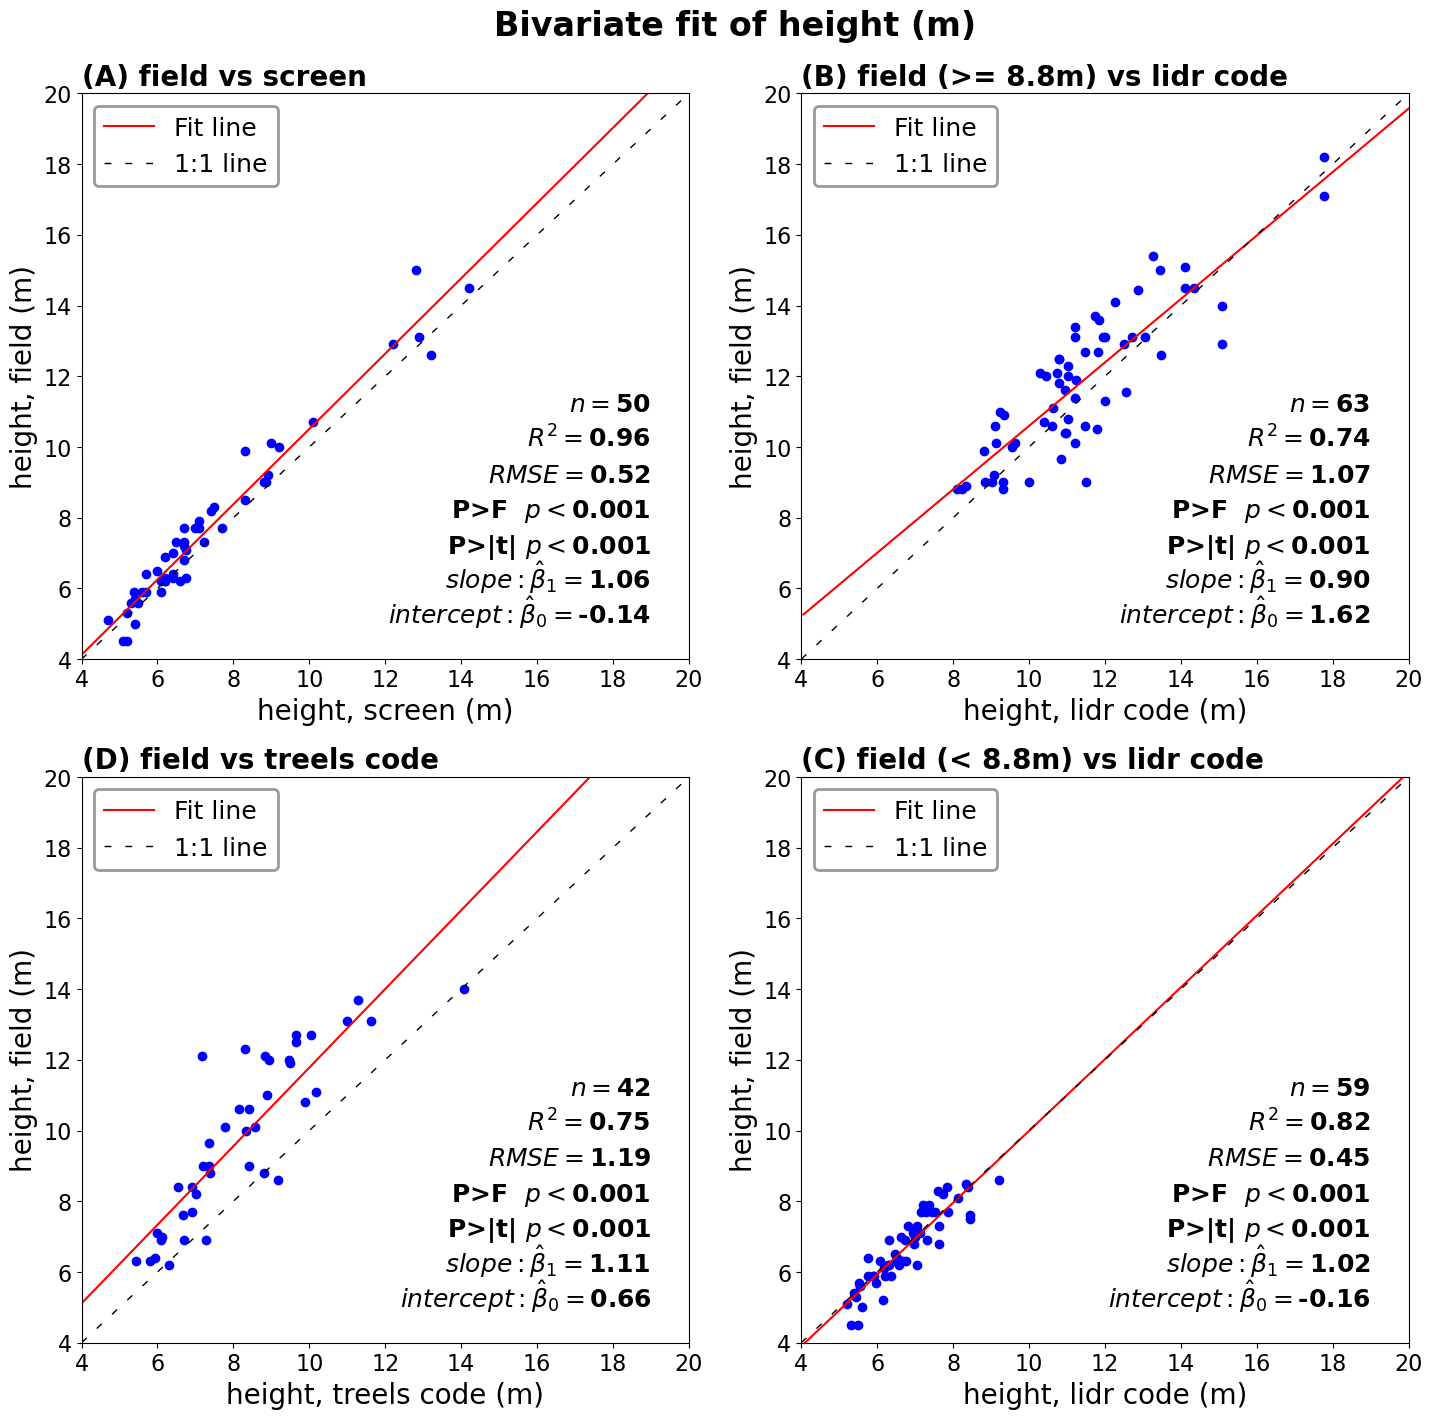

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (14, 14))
fig.tight_layout(h_pad=7, w_pad=5)
fig.subplots_adjust(top=0.92) # fraction of the figure height

title_font_size = 20
ax_title_font_size = 20
ax_tick_font_size = 16
text_font_size = 18
leg_font_size = 18

fig.suptitle('Bivariate fit of height (m)', size=title_font_size + 4, fontweight='bold')

text_x_start = 19
text_y_start = 11
step = 1

ax_min = 4
ax_max = 20

###
ax=ax1
###

data = inv_full_screen
xpar = 'h_m_mls'
ypar = 'h_m_f'

title = '(A) field vs screen'

x = data[xpar]
y = data[ypar]

x1 = np.array(x).reshape((-1,1))
model = LinearRegression().fit(x1, y)

r2 = model.score(x1,y)
coefficients = model.coef_
intercept = model.intercept_
rmse = math.sqrt(((((intercept+coefficients[0]*x)-y)**2).sum())/(len(y)-2))
pvf = sm.OLS(y, sm.add_constant(x)).fit().f_pvalue
pvt = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]

ax.scatter(x, y, color='b')

# Define parameters of the regression line
num = len(x)
start = x.min()
end = x.max()
xseq = np.linspace(start * .5, end * 1.5, num=num)

# Plot the line
ax.plot(xseq, intercept+coefficients[0]*xseq, color = 'r', linewidth = 1.5, 
        label = 'Fit line')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls=(0,(5,10)), color='k', linewidth=1, 
        label = '1:1 line')
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

num = r'$n =$' + str(len(data))
ax.text(text_x_start, text_y_start, num, fontsize=text_font_size, weight='bold', 
        horizontalalignment='right')

r_squared = r'$R^2 =$' + f'{r2:.2f}'
ax.text(text_x_start, text_y_start - step * 1, r_squared, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

rmse_text = r'$RMSE = $' + f'{rmse:.2f}'
ax.text(text_x_start, text_y_start - step * 2, rmse_text, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvf < 0.001: 
    pval = r'P>F  $p<$0.001'
else: 
    pval = r'P>F  $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 3, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvt < 0.001: 
    pval = r'P>|t| $p<$0.001'
else: 
    pval = r'P>|t| $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 4, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta1 = r'$slope: \hat\beta_1 =$' + f'{coefficients[0]:.2f}'
ax.text(text_x_start, text_y_start - step * 5, beta1, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta0 = r'$intercept: \hat\beta_0 =$' + f'{intercept:.2f}'
ax.text(text_x_start, text_y_start - step * 6, beta0, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

# Add a title and axis label
ax.set_title(title, size = title_font_size, fontweight='bold', loc = 'left')
ax.set_xlabel('height, screen (m)', size = ax_title_font_size)
ax.set_ylabel('height, field (m)', size = ax_title_font_size)
ax.tick_params(labelsize=ax_tick_font_size)

leg = ax.legend(loc = 'upper left', fontsize = leg_font_size)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)

###
ax=ax2
###

data = inv_full_above
xpar = 'h_m_tt'
ypar = 'h_m_f'

title = '(B) field (>= 8.8m) vs lidr code'

x = data[xpar]
y = data[ypar]

x1 = np.array(x).reshape((-1,1))
model = LinearRegression().fit(x1, y)

r2 = model.score(x1,y)
coefficients = model.coef_
intercept = model.intercept_
rmse = math.sqrt(((((intercept+coefficients[0]*x)-y)**2).sum())/(len(y)-2))
pvf = sm.OLS(y, sm.add_constant(x)).fit().f_pvalue
pvt = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]

ax.scatter(x, y, color='b')

# Define parameters of the regression line
num = len(x)
start = x.min()
end = x.max()
xseq = np.linspace(start * .5, end * 1.5, num=num)

# Plot the line
ax.plot(xseq, intercept+coefficients[0]*xseq, color = 'r', linewidth = 1.5, 
        label = 'Fit line')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls=(0,(5,10)), color='k', 
        linewidth=1, label = '1:1 line')
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

num = r'$n =$' + str(len(data))
ax.text(text_x_start, text_y_start, num, fontsize=text_font_size, weight='bold', 
        horizontalalignment='right')

r_squared = r'$R^2 =$' + f'{r2:.2f}'
ax.text(text_x_start, text_y_start - step * 1, r_squared, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

rmse_text = r'$RMSE = $' + f'{rmse:.2f}'
ax.text(text_x_start, text_y_start - step * 2, rmse_text, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvf < 0.001: 
    pval = r'P>F  $p<$0.001'
else: 
    pval = r'P>F  $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 3, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvt < 0.001: 
    pval = r'P>|t| $p<$0.001'
else: 
    pval = r'P>|t| $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 4, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta1 = r'$slope: \hat\beta_1 =$' + f'{coefficients[0]:.2f}'
ax.text(text_x_start, text_y_start - step * 5, beta1, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta0 = r'$intercept: \hat\beta_0 =$' + f'{intercept:.2f}'
ax.text(text_x_start, text_y_start - step * 6, beta0, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

# Add a title and axis label
ax.set_title(title, size = title_font_size, fontweight='bold', loc = 'left')
ax.set_xlabel('height, lidr code (m)', size = ax_title_font_size)
ax.set_ylabel('height, field (m)', size = ax_title_font_size)
ax.tick_params(labelsize=ax_tick_font_size)

leg = ax.legend(loc = 'upper left', fontsize = leg_font_size)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)

###
ax=ax3
###

data = inv_full_dt
xpar = 'h_m_tls'
ypar = 'h_m_f'

title = '(D) field vs treels code'

x = data[xpar]
y = data[ypar]

x1 = np.array(x).reshape((-1,1))
model = LinearRegression().fit(x1, y)

r2 = model.score(x1,y)
coefficients = model.coef_
intercept = model.intercept_
rmse = math.sqrt(((((intercept+coefficients[0]*x)-y)**2).sum())/(len(y)-2))
pvf = sm.OLS(y, sm.add_constant(x)).fit().f_pvalue
pvt = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]

ax.scatter(x, y, color='b')

# Define parameters of the regression line
num = len(x)
start = x.min()
end = x.max()
xseq = np.linspace(start * .5, end * 1.5, num=num)

# Plot the line
ax.plot(xseq, intercept+coefficients[0]*xseq, color = 'r', linewidth = 1.5, 
        label = 'Fit line')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls=(0,(5,10)), color='k', 
        linewidth=1, label = '1:1 line')
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

num = r'$n =$' + str(len(data))
ax.text(text_x_start, text_y_start, num, fontsize=text_font_size, weight='bold', 
        horizontalalignment='right')

r_squared = r'$R^2 =$' + f'{r2:.2f}'
ax.text(text_x_start, text_y_start - step * 1, r_squared, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

rmse_text = r'$RMSE = $' + f'{rmse:.2f}'
ax.text(text_x_start, text_y_start - step * 2, rmse_text, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvf < 0.001: 
    pval = r'P>F  $p<$0.001'
else: 
    pval = r'P>F  $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 3, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvt < 0.001: 
    pval = r'P>|t| $p<$0.001'
else: 
    pval = r'P>|t| $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 4, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta1 = r'$slope: \hat\beta_1 =$' + f'{coefficients[0]:.2f}'
ax.text(text_x_start, text_y_start - step * 5, beta1, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta0 = r'$intercept: \hat\beta_0 =$' + f'{intercept:.2f}'
ax.text(text_x_start, text_y_start - step * 6, beta0, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

# Add a title and axis label
ax.set_title(title, size = title_font_size, fontweight='bold', loc = 'left')
ax.set_xlabel('height, treels code (m)', size = ax_title_font_size)
ax.set_ylabel('height, field (m)', size = ax_title_font_size)
ax.tick_params(labelsize=ax_tick_font_size)

leg = ax.legend(loc = 'upper left', fontsize = leg_font_size)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)

###
ax=ax4
###

data = inv_full_below
xpar = 'h_m_tt'
ypar = 'h_m_f'

title = '(C) field (< 8.8m) vs lidr code'

x = data[xpar]
y = data[ypar]

x1 = np.array(x).reshape((-1,1))
model = LinearRegression().fit(x1, y)

r2 = model.score(x1,y)
coefficients = model.coef_
intercept = model.intercept_
rmse = math.sqrt(((((intercept+coefficients[0]*x)-y)**2).sum())/(len(y)-2))
pvf = sm.OLS(y, sm.add_constant(x)).fit().f_pvalue
pvt = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]

ax.scatter(x, y, color='b')

# Define parameters of the regression line
num = len(x)
start = x.min()
end = x.max()
xseq = np.linspace(start * .5, end * 5, num=num)

# Plot the line
ax.plot(xseq, intercept+coefficients[0]*xseq, color = 'r', linewidth = 1.5, 
        label = 'Fit line')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls=(0,(5,10)), color='k', 
        linewidth=1, label = '1:1 line')
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

num = r'$n =$' + str(len(data))
ax.text(text_x_start, text_y_start, num, fontsize=text_font_size, weight='bold', 
        horizontalalignment='right')

r_squared = r'$R^2 =$' + f'{r2:.2f}'
ax.text(text_x_start, text_y_start - step * 1, r_squared, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

rmse_text = r'$RMSE = $' + f'{rmse:.2f}'
ax.text(text_x_start, text_y_start - step * 2, rmse_text, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvf < 0.001: 
    pval = r'P>F  $p<$0.001'
else: 
    pval = r'P>F  $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 3, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvt < 0.001: 
    pval = r'P>|t| $p<$0.001'
else: 
    pval = r'P>|t| $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 4, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta1 = r'$slope: \hat\beta_1 =$' + f'{coefficients[0]:.2f}'
ax.text(text_x_start, text_y_start - step * 5, beta1, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta0 = r'$intercept: \hat\beta_0 =$' + f'{intercept:.2f}'
ax.text(text_x_start, text_y_start - step * 6, beta0, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

# Add a title and axis label
ax.set_title(title, size = title_font_size, fontweight='bold', loc = 'left')
ax.set_xlabel('height, lidr code (m)', size = ax_title_font_size)
ax.set_ylabel('height, field (m)', size = ax_title_font_size)
ax.tick_params(labelsize=ax_tick_font_size)

leg = ax.legend(loc = 'upper left', fontsize = leg_font_size)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)

plt.savefig(figpath + 'Scatter plots of heights 2x2.png', bbox_inches='tight')

# Show the plot 
plt.show() 

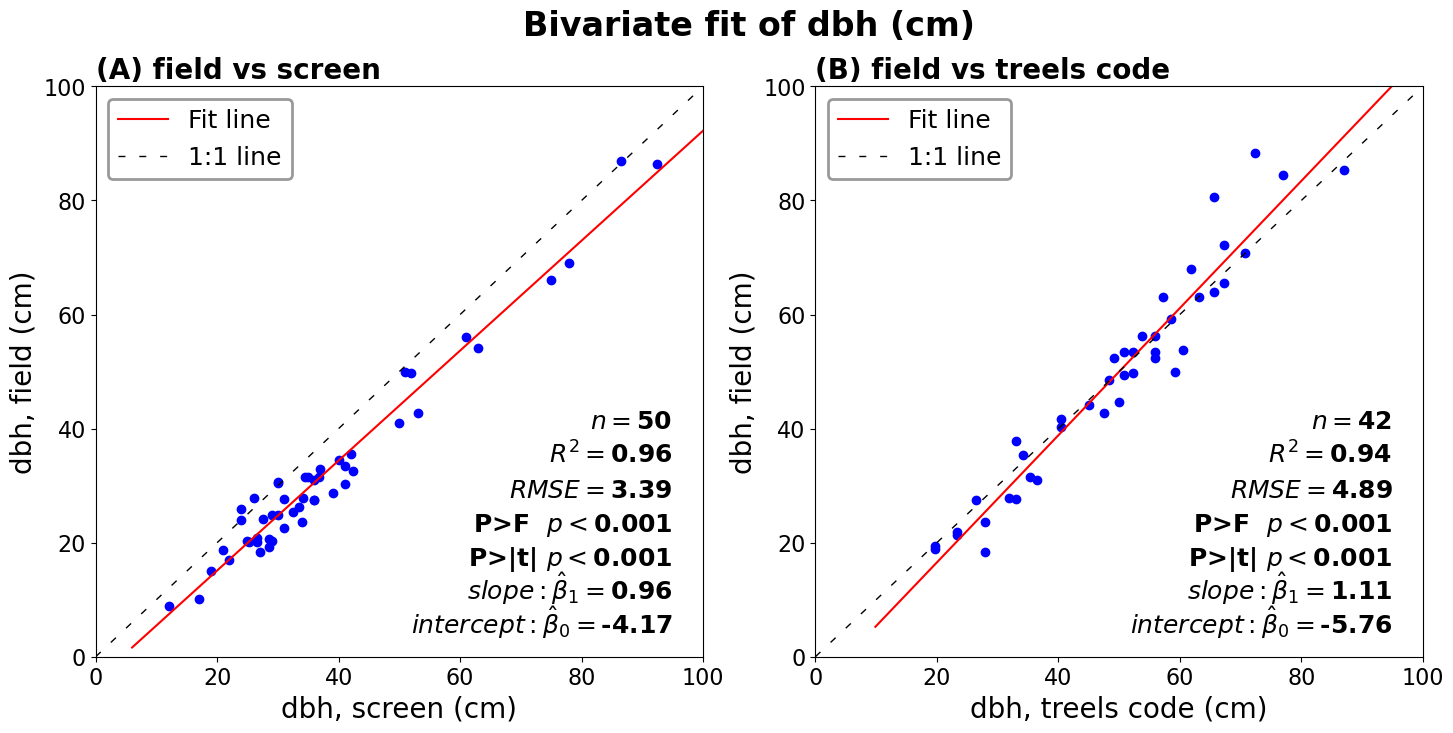

In [24]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (14, 7))
fig.tight_layout(h_pad=7, w_pad=5)
fig.subplots_adjust(top=0.87) # fraction of the figure height

title_font_size = 20
ax_title_font_size = 20
ax_tick_font_size = 16
text_font_size = 18
leg_font_size = 18

fig.suptitle('Bivariate fit of dbh (cm)', size = title_font_size + 4, fontweight='bold')

text_x_start = 95
text_y_start = 40
step = 6

ax_min = 0
ax_max = 100

###
ax=ax1
###

data = inv_full_screen
xpar = 'dbh_cm_mls'
ypar = 'dbh_cm_f'

title = '(A) field vs screen'

x = data[xpar]
y = data[ypar]

x1 = np.array(x).reshape((-1,1))
model = LinearRegression().fit(x1, y)

r2 = model.score(x1,y)
coefficients = model.coef_
intercept = model.intercept_
rmse = math.sqrt(((((intercept+coefficients[0]*x)-y)**2).sum())/(len(y)-2))
pvf = sm.OLS(y, sm.add_constant(x)).fit().f_pvalue
pvt = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]

ax.scatter(x, y, color='b')

# Define parameters of the regression line
num = len(x)
start = x.min()
end = x.max()
xseq = np.linspace(start * .5, end * 1.5, num=num)

# Plot the line
ax.plot(xseq, intercept+coefficients[0]*xseq, color = 'r', linewidth = 1.5, 
        label = 'Fit line')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls=(0,(5,10)), color='k', 
        linewidth=1, label = '1:1 line')
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

num = r'$n =$' + str(len(data))
ax.text(text_x_start, text_y_start, num, fontsize=text_font_size, weight='bold', 
        horizontalalignment='right')

r_squared = r'$R^2 =$' + f'{r2:.2f}'
ax.text(text_x_start, text_y_start - step * 1, r_squared, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

rmse_text = r'$RMSE = $' + f'{rmse:.2f}'
ax.text(text_x_start, text_y_start - step * 2, rmse_text, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvf < 0.001: 
    pval = r'P>F  $p<$0.001'
else: 
    pval = r'P>F  $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 3, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvt < 0.001: 
    pval = r'P>|t| $p<$0.001'
else: 
    pval = r'P>|t| $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 4, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta1 = r'$slope: \hat\beta_1 =$' + f'{coefficients[0]:.2f}'
ax.text(text_x_start, text_y_start - step * 5, beta1, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta0 = r'$intercept: \hat\beta_0 =$' + f'{intercept:.2f}'
ax.text(text_x_start, text_y_start - step * 6, beta0, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

# Add a title and axis label
ax.set_title(title, size = title_font_size, fontweight='bold', loc = 'left')
ax.set_xlabel('dbh, screen (cm)', size = ax_title_font_size)
ax.set_ylabel('dbh, field (cm)', size = ax_title_font_size)
ax.tick_params(labelsize=ax_tick_font_size)

leg = ax.legend(loc = 'upper left', fontsize = leg_font_size)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)

###
ax=ax2
###

data = inv_full_dt
xpar = 'dbh_cm_tls'
ypar = 'dbh_cm_f'

title = '(B) field vs treels code'

x = data[xpar]
y = data[ypar]

x1 = np.array(x).reshape((-1,1))
model = LinearRegression().fit(x1, y)

r2 = model.score(x1,y)
coefficients = model.coef_
intercept = model.intercept_
rmse = math.sqrt(((((intercept+coefficients[0]*x)-y)**2).sum())/(len(y)-2))
pvf = sm.OLS(y, sm.add_constant(x)).fit().f_pvalue
pvt = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]

ax.scatter(x, y, color='b')

# Define parameters of the regression line
num = len(x)
start = x.min()
end = x.max()
xseq = np.linspace(start * .5, end * 1.5, num=num)

# Plot the line
ax.plot(xseq, intercept+coefficients[0]*xseq, color = 'r', linewidth = 1.5, 
        label = 'Fit line')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls=(0,(5,10)), color='k', 
        linewidth=1, label = '1:1 line')
ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

num = r'$n =$' + str(len(data))
ax.text(text_x_start, text_y_start, num, fontsize=text_font_size, weight='bold', 
        horizontalalignment='right')

r_squared = r'$R^2 =$' + f'{r2:.2f}'
ax.text(text_x_start, text_y_start - step * 1, r_squared, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

rmse_text = r'$RMSE = $' + f'{rmse:.2f}'
ax.text(text_x_start, text_y_start - step * 2, rmse_text, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvf < 0.001: 
    pval = r'P>F  $p<$0.001'
else: 
    pval = r'P>F  $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 3, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

if pvt < 0.001: 
    pval = r'P>|t| $p<$0.001'
else: 
    pval = r'P>|t| $p=$' + f'{pv:.3f}'
ax.text(text_x_start, text_y_start - step * 4, pval, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta1 = r'$slope: \hat\beta_1 =$' + f'{coefficients[0]:.2f}'
ax.text(text_x_start, text_y_start - step * 5, beta1, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

beta0 = r'$intercept: \hat\beta_0 =$' + f'{intercept:.2f}'
ax.text(text_x_start, text_y_start - step * 6, beta0, fontsize=text_font_size, 
        weight='bold', horizontalalignment='right')

# Add a title and axis label
ax.set_title(title, size = title_font_size, fontweight='bold', loc = 'left')
ax.set_xlabel('dbh, treels code (cm)', size = ax_title_font_size)
ax.set_ylabel('dbh, field (cm)', size = ax_title_font_size)
ax.tick_params(labelsize=ax_tick_font_size)

leg = ax.legend(loc = 'upper left', fontsize = leg_font_size)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)

plt.savefig(figpath + 'Scatter plots of dbh 1x2.png', bbox_inches='tight')

# Show the plot 
plt.show() 

## Contact 

**Justinn J. Jones ’24, GISP**

Graduate Research Assistant / FAA sUAS RP

LASERS Lab / WFES 360

Department of Ecology & Conservation Biology

College of Agriculture & Life Sciences

justinn.j.jones@tamu.edu

**TEXAS A&M UNIVERSITY**